Dataset importing from sensor flw

In [ ]:

import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow.keras.applications import ResNet50

# Load the Malaria dataset
dataset, info = tfds.load('malaria', split='train', with_info=True)

# Get the number of images in the dataset
num_images = info.splits['train'].num_examples

print("Total number of images in the dataset:", num_images)

# Get the number of classes
num_classes = info.features['label'].num_classes


Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/1 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/27558 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/malaria/1.0.0.incomplete3T45RO/malaria-train.tfrecord*...:   0%|          …

Dataset malaria downloaded and prepared to /root/tensorflow_datasets/malaria/1.0.0. Subsequent calls will reuse this data.
Total number of images in the dataset: 27558


In [ ]:
# Get the total number of images in the dataset
num_images = info.splits['train'].num_examples

# Calculate the number of images you want (half of the dataset)
num_desired_images = num_images // 2  # Use integer division to get half

# Take a subset of the dataset with the desired number of examples
dataset = dataset.take(num_desired_images)

# Verify the number of examples in the subset
num_subset_images = len(list(dataset))  # Count the number of examples in the subset

print("Total number of images in the original dataset:", num_images)
print("Total number of images in the subset dataset (half of the original):", num_subset_images)

Total number of images in the original dataset: 27558
Total number of images in the subset dataset (half of the original): 13779


In [ ]:
# Initialize dictionary to store class counts
class_counts = {}

# Iterate through the dataset to count occurrences of each class

for example in dataset:
    # Extract class label (as integer)
    class_label = example['label'].numpy()  # Get the class label as an integer

    # Convert integer label to string
    class_name = str(class_label)

    # Update class count dictionary
    if class_name in class_counts:
        class_counts[class_name] += 1
    else:
        class_counts[class_name] = 1

# Display class counts
print("Number of images in each class:")
for class_name, count in class_counts.items():
    print(f"Class {class_name}: {count}")

Number of images in each class:
Class 1: 6899
Class 0: 6880


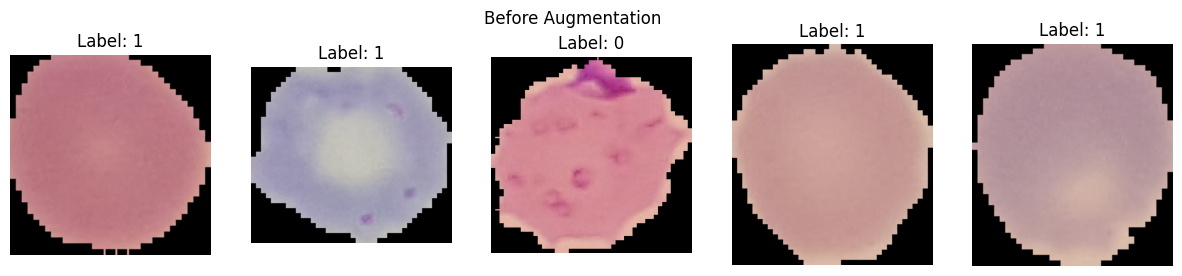

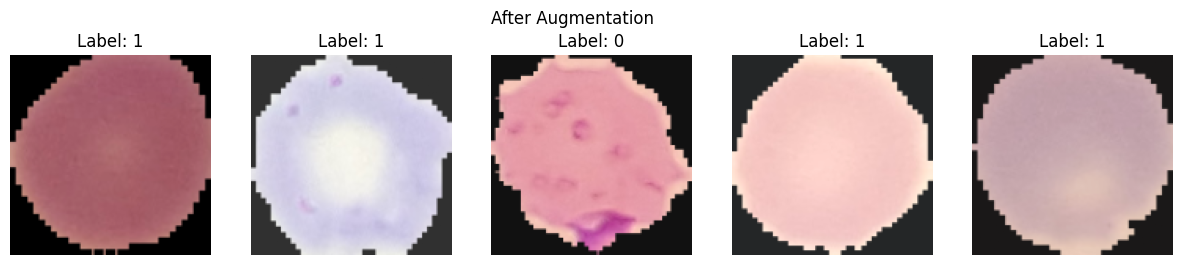

In [ ]:

# Display some images before augmentation
fig, axes = plt.subplots(1, 5, figsize=(15, 3))
fig.suptitle('Before Augmentation')

for i, data in enumerate(dataset.take(5)):
    image = data['image'].numpy()
    label = data['label'].numpy()

    axes[i].imshow(image)
    axes[i].set_title(f'Label: {label}')
    axes[i].axis('off')

plt.show()


# Define preprocessing and augmentation functions
def preprocess_augment(data):
    image = data['image']
    label = data['label']

    # Apply data augmentation
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_flip_up_down(image)
    image = tf.image.random_brightness(image, max_delta=0.2)
    image = tf.image.random_contrast(image, lower=0.8, upper=1.2)

    # Normalize the pixel values
    image = tf.image.resize(image, (128, 128))  # Example resizing for ResNet50 input shape
    image = image / 255.0

    return image, label

# Apply preprocessing and augmentation, and prepare the dataset
dataset_augmented = dataset.map(preprocess_augment)

# Display some images after augmentation
fig, axes = plt.subplots(1, 5, figsize=(15, 3))
fig.suptitle('After Augmentation')

for i, data in enumerate(dataset_augmented.take(5)):
    image = data[0].numpy()
    label = data[1].numpy()

    axes[i].imshow(image)
    axes[i].set_title(f'Label: {label}')
    axes[i].axis('off')

plt.show()

In [ ]:
# Split the dataset into training and validation
train_size = int(0.8 * num_subset_images)
val_size = num_subset_images - train_size

print("Number of images in the training set:", train_size)
print("Number of images in the validation set:", val_size)

train_dataset = dataset_augmented.take(train_size)
val_dataset = dataset_augmented.skip(train_size)

# Shuffle and batch the datasets
batch_size = 64
train_dataset = train_dataset.shuffle(buffer_size=1000).batch(batch_size).prefetch(tf.data.experimental.AUTOTUNE)
val_dataset = val_dataset.batch(batch_size).prefetch(tf.data.experimental.AUTOTUNE)

Number of images in the training set: 11023
Number of images in the validation set: 2756


In [ ]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.models import Model

# Load pre-trained ResNet50 model (without top layers)
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(128, 128, 3))

# Add custom classification head with additional dense layers
x = GlobalAveragePooling2D()(base_model.output)
x = Dense(1024, activation='relu')(x)
x = Dense(256, activation='relu')(x)  # Additional dense layer 1
x = Dense(128, activation='relu')(x)  # Additional dense layer 2
x = Dense(64, activation='relu')(x)   # Additional dense layer 3
outputs = Dense(num_classes, activation='softmax')(x)

# Create model
model = Model(inputs=base_model.input, outputs=outputs)

# Compile model
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Train model
model.fit(train_dataset, epochs=5)

94765736/94765736 [==============================] - 4s 0us/step
Epoch 1/5
173/173 [==============================] - 3200s 18s/step - loss: 0.1922 - accuracy: 0.9409
Epoch 2/5
173/173 [==============================] - 3061s 18s/step - loss: 0.1389 - accuracy: 0.9533
Epoch 3/5
173/173 [==============================] - 3087s 18s/step - loss: 0.1247 - accuracy: 0.9588
Epoch 4/5
173/173 [==============================] - 3038s 18s/step - loss: 0.1194 - accuracy: 0.9585
Epoch 5/5
173/173 [==============================] - 3036s 18s/step - loss: 0.1151 - accuracy: 0.9611


In [ ]:
model.save('my_model.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
# Make predictions on validation dataset
predictions = model.predict(val_dataset)

# Convert predictions to class labels (if needed)
predicted_labels = np.argmax(predictions, axis=1)

# Extract true labels from validation dataset
true_labels = np.concatenate([y for x, y in val_dataset], axis=0)

# Calculate confusion matrix
from sklearn.metrics import confusion_matrix

conf_matrix = confusion_matrix(true_labels, predicted_labels)
print("Confusion Matrix:")
print(conf_matrix)

44/44 [==============================] - 189s 4s/step
Confusion Matrix:
[[ 747  621]
 [   3 1385]]


2/2 [==============================] - 5s 3s/step


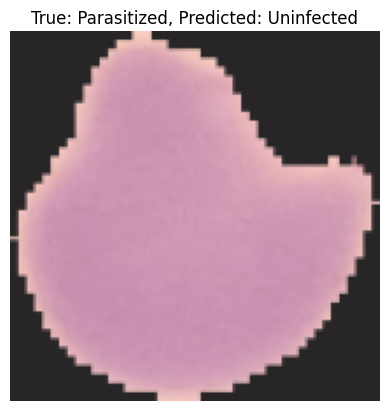

2/2 [==============================] - 3s 2s/step


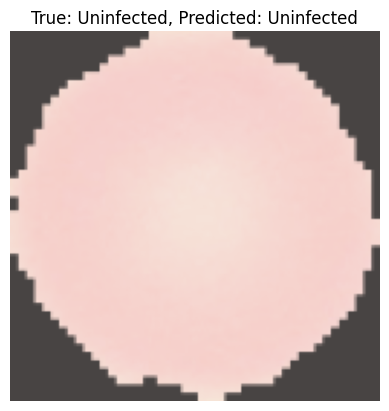

2/2 [==============================] - 4s 2s/step


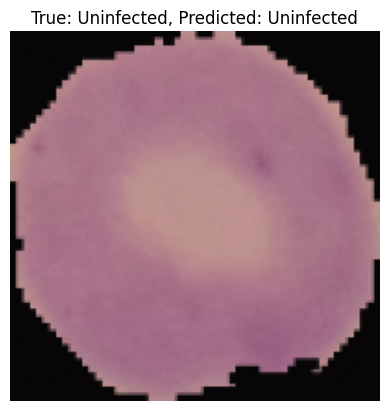

2/2 [==============================] - 5s 2s/step


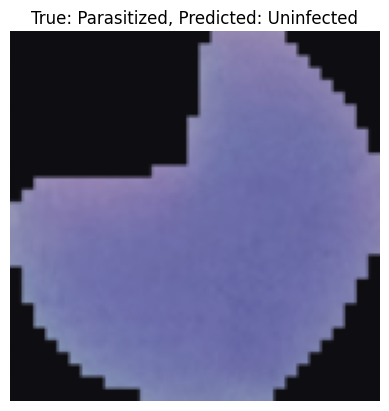

2/2 [==============================] - 3s 2s/step


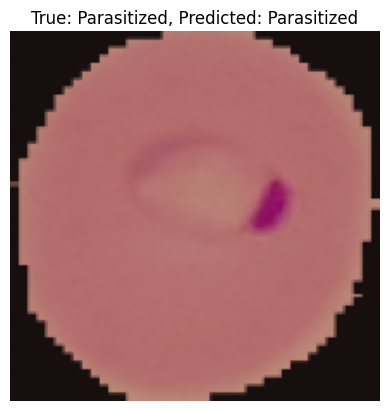

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

val_iterator = iter(val_dataset)
for _ in range(5):  # Print predictions for 5 batches
    images, labels = next(val_iterator)
    predictions = model.predict(images)

    # Randomly select a few images
    batch_size = images.shape[0]  # Get the batch size
    idx = np.random.choice(batch_size, 1, replace=False)

    for i in idx:
        image = images[i]
        label = labels[i]
        prediction = predictions[i]

        # Convert label and prediction to class names
        class_names = ['Parasitized', 'Uninfected']
        label_name = class_names[int(label)]

        # Determine predicted label based on probability threshold (e.g., 0.5)
        predicted_label = np.argmax(prediction)  # Get index of max probability class
        predicted_label_name = class_names[predicted_label]

        # Plot the image with true and predicted labels
        plt.figure()
        plt.imshow(image)
        plt.title(f'True: {label_name}, Predicted: {predicted_label_name}')
        plt.axis('off')
    plt.show()

44/44 [==============================] - 192s 4s/step


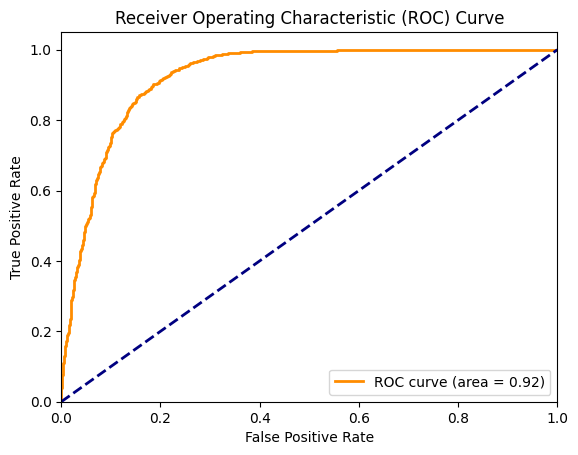

In [ ]:
# Make predictions on validation dataset
predictions = model.predict(val_dataset)

# Extract true labels from validation dataset
true_labels = np.concatenate([y for x, y in val_dataset], axis=0)

# Calculate ROC curve and AUC
from sklearn.metrics import roc_curve, auc

# Assuming the model output probabilities for each class, get the probabilities for the positive class
predicted_probabilities = predictions[:, 1]  # Assuming the positive class is index 1

# Compute ROC curve and AUC
fpr, tpr, thresholds = roc_curve(true_labels, predicted_probabilities)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
import matplotlib.pyplot as plt

plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange', lw=lw, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()
